# Sampling from SK model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fminbound
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

%matplotlib inline

In [2]:
def iterate_sc_equation(J, beta, s0=None, max_iter=None, tol=1e-7, verbose=True, approximation='MF'):
    """Iterate MF or TAP self-consistency equation"""
    
    # Some pre-processing
    size_x = J.shape[0]
    max_iter = max_iter or 100 * size_x
    
    # Initialize variables
    B = np.zeros(size_x)
    m = np.random.rand(size_x)
    m_old = np.zeros(size_x)
    
    for t in range(max_iter):
        # Perform iteration
        if approximation == 'TAP':
            B = beta * J.dot(m) - beta ** 2 * m_old * (J ** 2).dot(1 - m ** 2) 
        elif approximation == 'MF':
            B = beta * J.dot(m) 
        m_old = np.copy(m)
        m = np.tanh(B)
         
        # Compute metrics
        diff = np.mean(np.abs(m - m_old))
        
        # Print iteration status on screen
        if verbose:
            print("t = %d, diff = %g" % (t, diff))
        
        # Check for convergence
        if diff < tol:
            break
            
    return m

In [3]:
fs=30  # label fontsize
fsl=20 # legend fontsize

## Point a)  
* Write a code to perform the MCMC dynamics, and start by configurations extracted uniformly at random.  
    * i) Sample a particular realization of $\mathbf{J}\sim \mathcal{N}(0,\sigma^{2} / \sqrt{N})$, for $\sigma^{2}=1$ and $ \beta = 1.1$. 
    * ii) Run your dynamics for a long enough time (say, with $ t_{\mathrm{max}} = 10^{3} N $ attempts to flips spins) and monitor the value of the magnetization $ m = \sum_i s_i/N $ as a function of time.   

Make a plot for $ N=10,100,1000 $ spins. 


In [4]:
def sample_instance(N, var_noise):
    """Sample {J} from P(J)= Normal(0, var_noise)"""
    
    noise = np.sqrt(var_noise) * np.random.randn(N, N) / np.sqrt(N) 
    noise = np.tril(noise) + np.tril(noise).T  # make noise symmetric
    J = noise
    np.fill_diagonal(J, 0)  # set diagonal elements to zero

    return J

Example call

In [5]:
J = sample_instance(100, 0.1)
iterate_sc_equation(J, 1., verbose=True, max_iter=20, approximation='TAP')

t = 0, diff = 0.500229
t = 1, diff = 0.163747
t = 2, diff = 0.0491488
t = 3, diff = 0.0178125
t = 4, diff = 0.00571597
t = 5, diff = 0.00175286
t = 6, diff = 0.000473069
t = 7, diff = 0.000132117
t = 8, diff = 3.97562e-05
t = 9, diff = 1.26156e-05
t = 10, diff = 4.86721e-06
t = 11, diff = 1.55077e-06
t = 12, diff = 5.22346e-07
t = 13, diff = 1.82051e-07
t = 14, diff = 5.4413e-08


array([ 3.16463802e-08, -8.00214685e-09,  5.87035074e-09, -6.45536502e-09,
       -1.08331826e-08,  8.22478920e-09, -6.29239263e-09,  3.44710532e-08,
        2.11043682e-08, -1.87512312e-09,  3.91968146e-08,  7.73970086e-09,
        1.18003737e-09,  2.90979625e-08, -8.33831030e-10,  1.85606480e-09,
       -3.77978070e-09, -7.46329579e-10, -7.93167545e-09, -1.10170194e-08,
       -6.82200170e-09, -4.23265240e-08,  1.67264594e-09,  1.65562894e-08,
        1.75638130e-08,  3.41657875e-08, -6.35253452e-09,  1.79457929e-10,
        2.51484097e-08, -6.81444970e-09,  7.23849173e-09, -1.56059615e-08,
       -3.82450156e-09,  2.09595808e-08,  5.89560754e-09, -2.30902993e-08,
       -1.78252696e-08,  3.34779412e-09,  1.63033002e-08,  1.48061990e-08,
       -2.85707953e-08,  1.06827326e-08,  1.71401541e-08,  1.21049996e-08,
        2.56858472e-09, -2.69867904e-08, -7.04377381e-10,  1.04839525e-08,
        7.39446658e-09,  1.64046330e-09, -2.86349803e-08,  1.17516227e-08,
        4.70416887e-09,  

In [6]:
def SK_simul(N, beta, J, t_max=None, t_eq=None):
    t_max = t_max or 1000 * N     # max number of iterations 
    t_eq = t_eq or 10 * N         # number of MCMC iterations before convergence
    S = np.random.choice([+1, -1], N)       
    delta_E = lambda S, k: -2 * S[k] * np.dot(J[k, :], S) 
    
    m = np.full(t_max - t_eq, np.nan)     # average magnetization for every new sample
    m_complete = np.zeros(N)              # to compute magnetization for every index
    count = 0
    for t in range(t_max):
        k, r = np.random.randint(0, N), np.random.uniform(0, 1)
        if r < np.exp(beta * delta_E(S, k)):
            S[k] = -S[k]
            if t >= t_eq:
                m[t - t_eq] = S.mean()
                m_complete = m_complete + S
                count += 1
    return m, m_complete / float(count)

In [9]:
beta = 1.1
N_list = [10, 100, 500]
var_noise = 1


Running MCMC for N =  10
Finding m* for MF and TAP approximations for N = 10

Running MCMC for N =  100
Finding m* for MF and TAP approximations for N = 100

Running MCMC for N =  500
Finding m* for MF and TAP approximations for N = 500


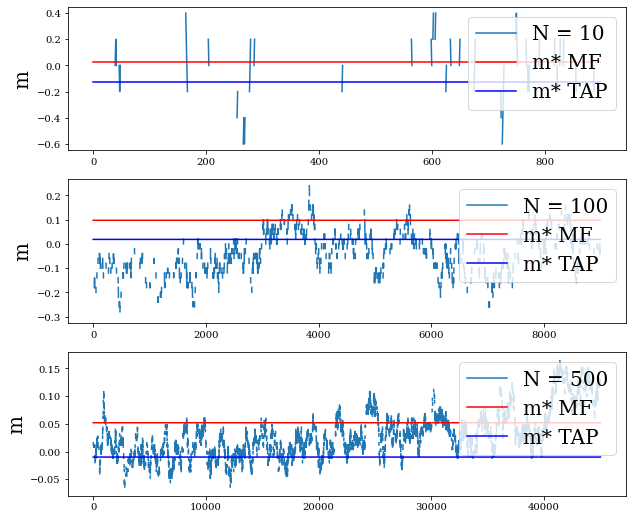

In [10]:

fig, ax = plt.subplots(len(N_list), figsize=(10, 3 * len(N_list)))
for i, N in enumerate(N_list):
    J = sample_instance(N, var_noise)
    print('\nRunning MCMC for N = ', N) 
    m, _ = SK_simul(N, beta, J, t_max=100*N)
    print('Finding m* for MF and TAP approximations for N =', N)
    m_mf = iterate_sc_equation(J, beta, approximation='MF', verbose=False)
    m_tap = iterate_sc_equation(J, beta, approximation='TAP', verbose=False)
    ax[i].plot(m, label='N = {0}'.format(N))
    ax[i].plot(np.ones_like(m) * m_mf.mean(), label='m* MF', c='r')
    ax[i].plot(np.ones_like(m) * m_tap.mean(), label='m* TAP', c='b')
    ax[i].legend(loc='upper right',fontsize=20)
    ax[i].set_ylabel('m',fontsize=20)
# plt.savefig('./figures/SK_MCMC_sample_ex2a.png', bbox_inches='tight')    

## Point b)  
*  Iterate MF and TAP equations and compare the values obtained from the ground truth MCMC sampler.  To do so, draw a scatter plot of the single values $m_i$ obtained from the MCMC sampler and the approximations (one plot per approximation, for a total of 2 plots).   
Comment.   

Similarly to before, implement the consistency equations as:
        \begin{align*}
		m_i^{(t+1)} &= \tanh \left( \beta \sum_j J_{ij} \, m_j^{(t)}  \right)   & \mbox{Mean Field}   	\\
			m_i^{(t+1)} &= \tanh \left(  
				\beta \sum_j J_{ij} \, m_j^{(t)}  - 
				\beta^2  m_i^{(t-1)}  \sum_j  J_{ij}^{2}\,(1 - (m_j^{(t)})^2)   \right)      
				& \mbox{TAP}   	\\
\end{align*}



Iterating MF fixed point equations for N = 10
Iterating TAP fixed point equations for N = 10
Running Metropolis-Hastings sampler 

Iterating MF fixed point equations for N = 100
Iterating TAP fixed point equations for N = 100
Running Metropolis-Hastings sampler 

Iterating MF fixed point equations for N = 500
Iterating TAP fixed point equations for N = 500
Running Metropolis-Hastings sampler 


Text(0.5, 0, '$m_{MCMC}$')

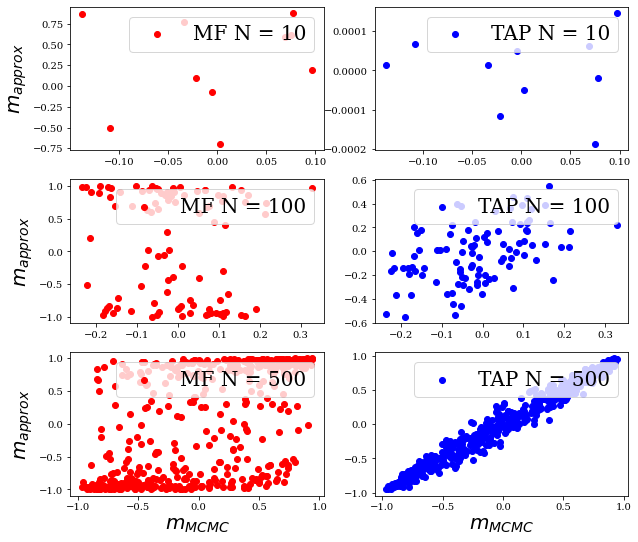

In [12]:
np.random.seed(2314)
var_noise=1.
fig, ax = plt.subplots(len(N_list), 2, figsize=(10, 3 * len(N_list)))
for i, N in enumerate(N_list):
    J = sample_instance(N, var_noise)   
    print(f'\nIterating MF fixed point equations for N = {N}')
    m_mf = iterate_sc_equation(J, beta, tol=1e-4, verbose=False, approximation='MF')
    print(f'Iterating TAP fixed point equations for N = {N}')
    m_tap = iterate_sc_equation(J, beta, tol=1e-4, verbose=False, approximation='TAP')
    print('Running Metropolis-Hastings sampler ')
    _, m_gt = SK_simul(N, beta, J)
    ax[i, 0].scatter(m_gt, m_mf, label=f'MF N = {N}', c='r')
    ax[i, 1].scatter(m_gt, m_tap, label=f'TAP N = {N}', c='b')
    ax[i, 0].legend(loc='upper right',fontsize=20)
    ax[i, 1].legend(loc='upper right',fontsize=20)
    ax[i, 0].set_ylabel(r'$m_{approx}$',fontsize=20)
ax[-1, 0].set_xlabel(r'$m_{MCMC}$',fontsize=20)
ax[-1, 1].set_xlabel(r'$m_{MCMC}$',fontsize=20)
# plt.savefig('./figures/MF_vs_TAP_MSE_sample_ex2b.png', bbox_inches='tight')